In [26]:
"""
VGG Scene Similarity Experiment
Compares frames using VGG16 fc7 features
"""

import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image

# Load VGG model and extract fc7 features
def load_vgg_model():
    """Load pretrained VGG16 and prepare for fc7 extraction"""
    ## load resnet on places365
    vgg = models.vgg16(pretrained=True)
    
    # Load model architecture
    model = models.resnet50(num_classes=365)

    # Load pre-trained Places365 weights
    checkpoint = torch.load(r'C:\kela\tracker\object-tracker\models\resnet50_places365.pth.tar', map_location='cpu')
    state_dict = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)

    model.eval()

    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

    vgg.eval()
    
    if torch.cuda.is_available():
        vgg = vgg.cuda()
        model = model.cuda()
    
    # Create feature extractor up to fc7
    # VGG structure: features -> avgpool -> classifier
    # fc7 is classifier[4] (after ReLU of fc6)
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    
    return feature_extractor

# Preprocessing transform (ImageNet standard)
def get_transform():
    """Standard VGG preprocessing"""
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

def extract_fc7_features(model, frame, transform):
    """Extract fc7 features from a frame"""
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    # Preprocess
    img_tensor = transform(pil_image).unsqueeze(0)
    
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()
    
    # Extract fc7 features
    with torch.no_grad():
        features = model(img_tensor)
    
    return features.cpu().numpy().flatten()

def compute_similarity(feat1, feat2):
    """Euclidean distance between two feature vectors"""
    return np.linalg.norm(feat2-feat1)

def analyze_video(video_path, sample_every=1):
    """
    Analyze video and compute similarity to first frame using VGG fc7
    
    Args:
        video_path: path to video file
        sample_every: sample every N frames (default: every frame)
    
    Returns:
        similarities: array of similarity scores
        frame_indices: corresponding frame numbers
    """
    print("Loading VGG16 model...")
    model = load_vgg_model()
    transform = get_transform()
    
    print(f"Opening video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    # Get first frame
    ret, first_frame = cap.read()
    if not ret:
        raise ValueError("Could not read first frame")
    ## GET 30% of the middle from the first frame
    first_frame_height, first_frame_width = first_frame.shape[:2]
    crop_y1 = int(first_frame_height * 0.35)
    crop_x1 = int(first_frame_width * 0.35)
    crop_y2 = int(first_frame_height * 0.65)
    crop_x2 = int(first_frame_width * 0.65)
    first_frame= first_frame
    print("Extracting reference features from first frame (fc7)...")
    reference_features = extract_fc7_features(model, first_frame, transform)
    ## scale first frame
    #reference_features_double = extract_fc7_features(model, cv2.resize(first_frame, None, fx=2.0, fy=2.0), transform)
    #reference_features_half = extract_fc7_features(model, cv2.resize(first_frame, None, fx=0.5, fy=0.5), transform)
    #reference_features_rotate_right = extract_fc7_features(model, cv2.rotate(first_frame, cv2.ROTATE_90_CLOCKWISE), transform)
    #reference_features_rotate_left = extract_fc7_features(model, cv2.rotate(first_frame, cv2.ROTATE_90_COUNTERCLOCKWISE), transform)

    ## average the features
    #reference_features = (reference_features_original + reference_features_double + reference_features_half + reference_features_rotate_right + reference_features_rotate_left) / 5.0
    # Process remaining frames
    similarities = [1.0]  # First frame similarity to itself
    frame_indices = [0]
    frame_count = 1
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Processing {total_frames} frames (sampling every {sample_every})...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % sample_every == 0:
                features = extract_fc7_features(model, frame, transform)
                sim = compute_similarity(reference_features, features)
                similarities.append(sim)
                frame_indices.append(frame_count)
            
        if frame_count % 100 == 0:
                print(f"Processed {frame_count}/{total_frames} frames...")
        
        frame_count += 1
    
    cap.release()
    print("Done!")
    
    return np.array(similarities), np.array(frame_indices)

def analyze_video_with_roi(video_path, sample_every=1, resize_factor=0.3):
    """
    Analyze video with ROI selection - compares ROI region across frames
    
    Args:
        video_path: path to video file
        sample_every: sample every N frames
        resize_factor: factor to resize display for ROI selection
    
    Returns:
        similarities: array of similarity scores
        frame_indices: corresponding frame numbers
        roi: (x, y, w, h) tuple of ROI coordinates
    """
    print("Loading VGG16 model...")
    model = load_vgg_model()
    transform = get_transform()
    
    print(f"Opening video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    # Get first frame and select ROI
    ret, first_frame = cap.read()
    if not ret:
        raise ValueError("Could not read first frame")
    
    # Resize for display
    resize_for_display = cv2.resize(
        first_frame, 
        (int(first_frame.shape[1]*resize_factor), 
         int(first_frame.shape[0]*resize_factor))
    )
    
    print("Select ROI (press ENTER when done, ESC to cancel)")
    roi = cv2.selectROI("Select ROI", resize_for_display, showCrosshair=True)
    cv2.destroyAllWindows()
    
    # Scale ROI back to original frame size
    x, y, w, h = roi
    x = int(x / resize_factor)
    y = int(y / resize_factor)
    w = int(w / resize_factor)
    h = int(h / resize_factor)
    
    print(f"ROI selected: x={x}, y={y}, w={w}, h={h}")
    
    # Extract features from ROI of first frame
    first_frame_roi = first_frame[y:y+h, x:x+w]
    
    print("Extracting reference features from ROI (fc7)...")
    reference_features = extract_fc7_features(model, first_frame_roi, transform)
    
    # Process remaining frames
    similarities = [1.0]  # First frame similarity to itself
    frame_indices = [0]
    frame_count = 1
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Processing {total_frames} frames (sampling every {sample_every})...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % sample_every == 0:
            # Extract same ROI region from current frame
            frame_roi = frame[y:y+h, x:x+w]
            features = extract_fc7_features(model, frame_roi, transform)
            sim = compute_similarity(reference_features, features)
            similarities.append(sim)
            frame_indices.append(frame_count)
            
            if frame_count % 100 == 0:
                print(f"Processed {frame_count}/{total_frames} frames...")
        
        frame_count += 1
    
    cap.release()
    print("Done!")
    
    return np.array(similarities), np.array(frame_indices), (x, y, w, h)

def plot_results(similarities, frame_indices, fps=30, threshold=0.8):
    """Plot similarity over time with potential scene change markers"""
    plt.figure(figsize=(14, 6))
    
    # Convert frame indices to time in seconds
    time_seconds = frame_indices / fps
    
    plt.subplot(1, 2, 1)
    plt.plot(time_seconds, similarities, linewidth=1.5)
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.xlabel('Time (seconds)')
    plt.xticks(np.arange(0, time_seconds[-1] + 1, 10))
    plt.ylabel('Cosine Similarity to First Frame')
    plt.title('Scene Similarity Over Time (VGG fc7)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Detect potential scene changes
    scene_changes = frame_indices[similarities < threshold]
    
    plt.subplot(1, 2, 2)
    plt.hist(similarities, bins=50, edgecolor='black')
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Similarity Scores')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    if len(scene_changes) > 0:
        print(f"\nPotential scene changes detected at frames: {scene_changes[:10]}...")
        print(f"Total frames below threshold: {len(scene_changes)}")
        print(f"Time points (seconds): {scene_changes[:10] / fps}")
    else:
        print(f"\nNo frames below threshold {threshold}")
    
    print(f"\nSimilarity stats:")
    print(f"  Min: {similarities.min():.3f}")
    print(f"  Max: {similarities.max():.3f}")
    print(f"  Mean: {similarities.mean():.3f}")
    print(f"  Std: {similarities.std():.3f}")

# Example usage (run in Jupyter):
"""
# Option 1: Full frame comparison
video_path = "your_video.mp4"
similarities, frame_indices = analyze_video(video_path, sample_every=5)
plot_results(similarities, frame_indices, fps=30, threshold=0.8)

# Option 2: ROI-based comparison (for stationary camera)
similarities, frame_indices, roi = analyze_video_with_roi(video_path, sample_every=5)
plot_results(similarities, frame_indices, fps=30, threshold=0.8)
print(f"ROI used: {roi}")
"""

'\n# Option 1: Full frame comparison\nvideo_path = "your_video.mp4"\nsimilarities, frame_indices = analyze_video(video_path, sample_every=5)\nplot_results(similarities, frame_indices, fps=30, threshold=0.8)\n\n# Option 2: ROI-based comparison (for stationary camera)\nsimilarities, frame_indices, roi = analyze_video_with_roi(video_path, sample_every=5)\nplot_results(similarities, frame_indices, fps=30, threshold=0.8)\nprint(f"ROI used: {roi}")\n'

Loading VGG16 model...


c:\kela\tracker\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\kela\tracker\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Opening video: C:\kela\tracker\object-tracker\data\input\MAX_0008.mp4
Extracting reference features from first frame (fc7)...
Processing 6534 frames (sampling every 5)...
Processed 100/6534 frames...
Processed 200/6534 frames...
Processed 300/6534 frames...
Processed 400/6534 frames...
Processed 500/6534 frames...
Processed 600/6534 frames...
Processed 700/6534 frames...
Processed 800/6534 frames...
Processed 900/6534 frames...
Processed 1000/6534 frames...
Processed 1100/6534 frames...
Processed 1200/6534 frames...
Processed 1300/6534 frames...
Processed 1400/6534 frames...
Processed 1500/6534 frames...
Processed 1600/6534 frames...
Processed 1700/6534 frames...
Processed 1800/6534 frames...
Processed 1900/6534 frames...
Processed 2000/6534 frames...
Processed 2100/6534 frames...
Processed 2200/6534 frames...
Processed 2300/6534 frames...
Processed 2400/6534 frames...
Processed 2500/6534 frames...
Processed 2600/6534 frames...
Processed 2700/6534 frames...
Processed 2800/6534 frames..

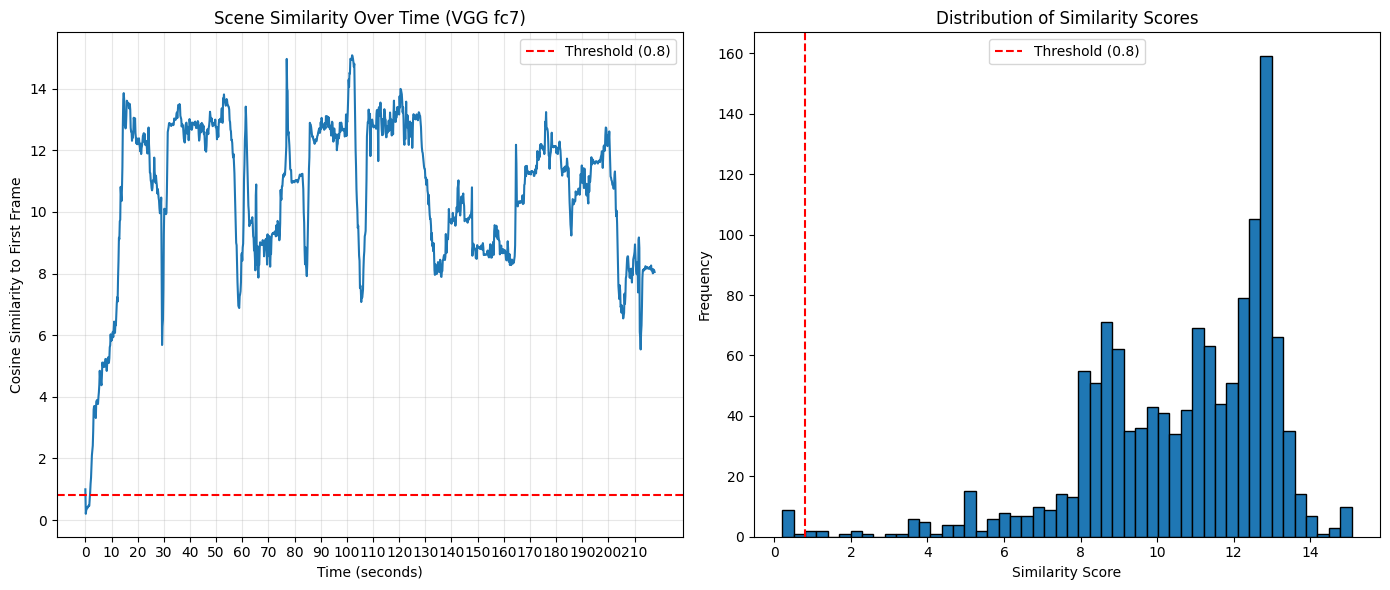


Potential scene changes detected at frames: [ 5 10 15 20 25 30 35 40 45 50]...
Total frames below threshold: 10
Time points (seconds): [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.
 1.16666667 1.33333333 1.5        1.66666667]

Similarity stats:
  Min: 0.205
  Max: 15.084
  Mean: 10.590
  Std: 2.491


In [27]:
video_path =  r"C:\kela\tracker\object-tracker\data\input\MAX_0008.mp4" 
similarities, frame_indices = analyze_video(video_path, sample_every=5)
plot_results(similarities, frame_indices, fps=30, threshold=0.8)

Loading VGG16 model...
Opening video: C:\kela\tracker\object-tracker\data\input\MAX_0009.mp4
Extracting reference features from first frame (fc7)...
Processing 6431 frames (sampling every 5)...
Processed 100/6431 frames...
Processed 200/6431 frames...
Processed 300/6431 frames...
Processed 400/6431 frames...
Processed 500/6431 frames...
Processed 600/6431 frames...
Processed 700/6431 frames...
Processed 800/6431 frames...
Processed 900/6431 frames...
Processed 1000/6431 frames...
Processed 1100/6431 frames...
Processed 1200/6431 frames...
Processed 1300/6431 frames...
Processed 1400/6431 frames...
Processed 1500/6431 frames...
Processed 1600/6431 frames...
Processed 1700/6431 frames...
Processed 1800/6431 frames...
Processed 1900/6431 frames...
Processed 2000/6431 frames...
Processed 2100/6431 frames...
Processed 2200/6431 frames...
Processed 2300/6431 frames...
Processed 2400/6431 frames...
Processed 2500/6431 frames...
Processed 2600/6431 frames...
Processed 2700/6431 frames...
Proce

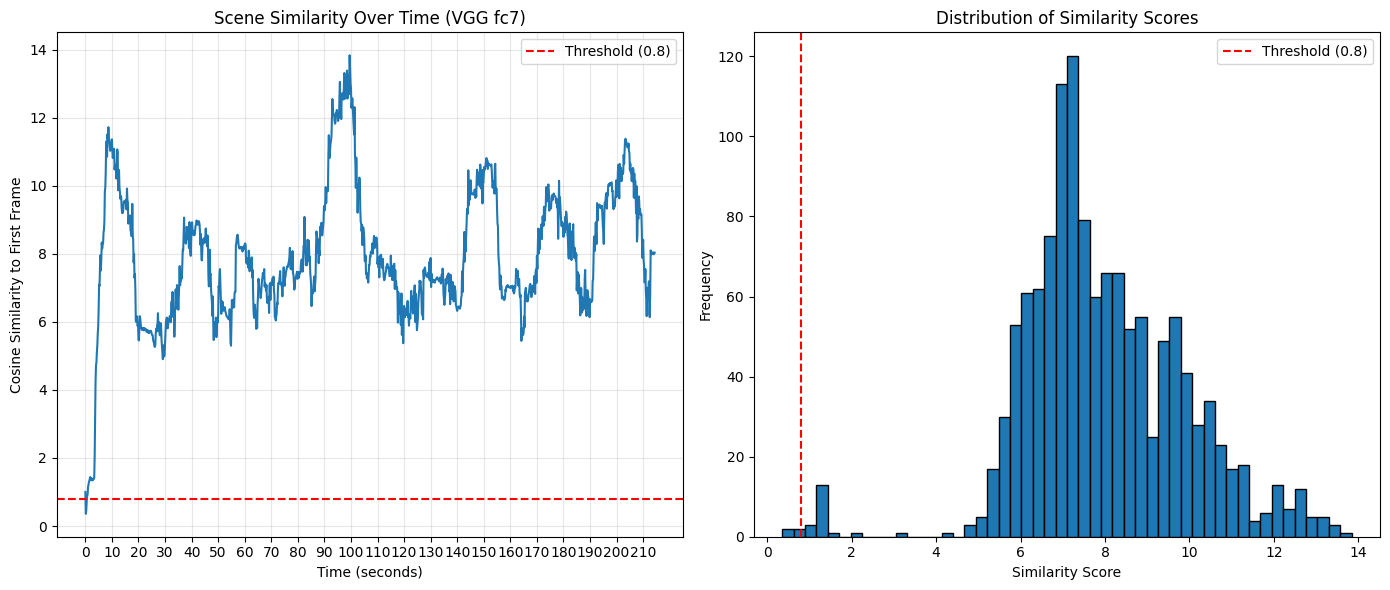


Potential scene changes detected at frames: [ 5 10 15]...
Total frames below threshold: 3
Time points (seconds): [0.16666667 0.33333333 0.5       ]

Similarity stats:
  Min: 0.359
  Max: 13.836
  Mean: 7.966
  Std: 1.936


In [28]:
video_path =  r"C:\kela\tracker\object-tracker\data\input\MAX_0009.mp4" 
similarities, frame_indices = analyze_video(video_path, sample_every=5)
plot_results(similarities, frame_indices, fps=30, threshold=0.8)

In [15]:
from ultralyticsplus import YOLO, postprocess_classify_output

# load model
model = YOLO('keremberke/yolov8m-scene-classification')

# set model parameters
model.overrides['conf'] = 0.25  # model confidence threshold

# set image
image = 'https://github.com/ultralytics/yolov5/raw/master/data/images/zidane.jpg'

# perform inference
results = model.predict(image)

# observe results
print(results[0].probs) # [0.1, 0.2, 0.3, 0.4]
processed_result = postprocess_classify_output(model, result=results[0])
print(processed_result) # {"cat": 0.4, "dog": 0.6}

ModuleNotFoundError: No module named 'ultralyticsplus'

Loading VGG16 model...


c:\kela\tracker\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\kela\tracker\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Opening video: C:\kela\tracker\object-tracker\data\input\MAX_0008.mp4
Extracting reference features from first frame (fc7)...
Processing 6534 frames (sampling every 5)...
Processed 100/6534 frames...
Processed 200/6534 frames...
Processed 300/6534 frames...
Processed 400/6534 frames...
Processed 500/6534 frames...
Processed 600/6534 frames...
Processed 700/6534 frames...
Processed 800/6534 frames...
Processed 900/6534 frames...
Processed 1000/6534 frames...
Processed 1100/6534 frames...
Processed 1200/6534 frames...
Processed 1300/6534 frames...
Processed 1400/6534 frames...
Processed 1500/6534 frames...
Processed 1600/6534 frames...
Processed 1700/6534 frames...
Processed 1800/6534 frames...
Processed 1900/6534 frames...
Processed 2000/6534 frames...
Processed 2100/6534 frames...
Processed 2200/6534 frames...
Processed 2300/6534 frames...
Processed 2400/6534 frames...
Processed 2500/6534 frames...
Processed 2600/6534 frames...
Processed 2700/6534 frames...
Processed 2800/6534 frames..

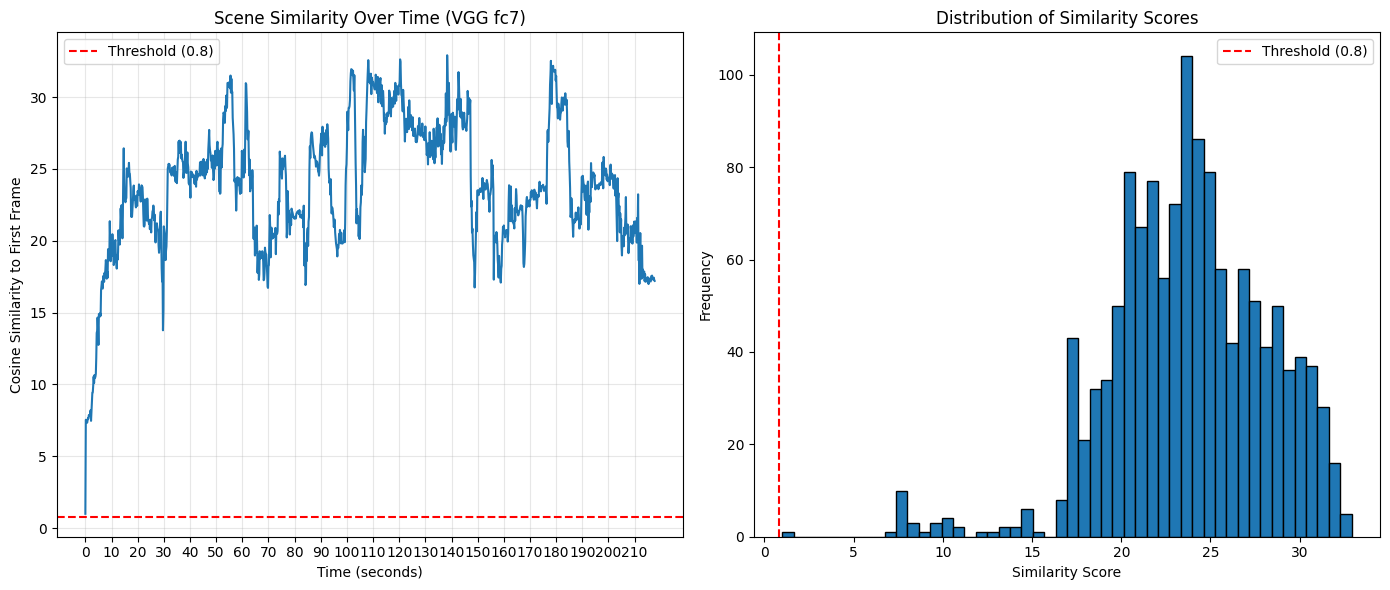


No frames below threshold 0.8

Similarity stats:
  Min: 1.000
  Max: 32.907
  Mean: 23.769
  Std: 4.428


In [8]:
video_path =  r"C:\kela\tracker\object-tracker\data\input\MAX_0008.mp4" 
similarities, frame_indices = analyze_video(video_path, sample_every=5)
plot_results(similarities, frame_indices, fps=30, threshold=0.8)